In [1]:
import os

#add the root directory
os.chdir('../')

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
from PCAfold import normalized_variance_derivative, cost_function_normalized_variance_derivative
import numpy as np
import pandas as pd
import torch
from loader import *
import matplotlib.pyplot as plt
import h5py
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from utils import *
from tools import *
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from matplotlib.patches import Patch
from matplotlib.patches import Ellipse
import matplotlib.colors as colors

logging.disable(logging.CRITICAL) #disable the logging

# Figures 2: Encoder-decoder with vs. without scaling layer</Br>
Comparison and analysis of encoder-decoders with and without the scaling layer prior to the encoder.

In [ ]:
namesWithout_0D = ["2pW", "2qW", "2rW", "2sW","2tW", "2uW"] 
namesWith_0D = ["2p", "2q", "2r", "2s","2t", "2u"]

MSE_NN_without_0D = []
MSE_NN_with_0D = []

path_MSE_NN = "paper/data/"
my_seed = 7
lr = 0.01

for nameWithout, nameWith in zip(namesWithout_0D, namesWith_0D):
    MSE_NN_without_0D.append(np.load(f"{path_MSE_NN}MSE_Val_NN_Tr0D-{nameWithout}_autoignition_s{my_seed}_lr{lr}_scaleManifoldTrue.npy"))
    MSE_NN_with_0D.append(np.load(f"{path_MSE_NN}MSE_Val_NN_Tr0D-{nameWith}_autoignition_s{my_seed}_lr{lr}_scaleManifoldTrue.npy"))

MSE_NN_without_0D = np.array(MSE_NN_without_0D).flatten().tolist()
MSE_NN_with_0D = np.array(MSE_NN_with_0D).flatten().tolist()

MSE_NN_without_0D.pop(2)
MSE_NN_with_0D.pop(0) #remove first and second index
MSE_NN_with_0D.pop(0)


names_without_0D = ["0D-2pW", "0D-2qW", "0D-2rW", "0D-2sW", "0D-2tW", "0D-2uW"] #, "32j"
names_with_0D = ["0D-2p", "0D-2q", "0D-2r", "0D-2s", "0D-2t", "0D-2u"]

cost_avg_without_0D = []
cost_avg_with_0D = []

cost_PVsource_without_0D = []
cost_PVsource_with_0D = []

for i in range(len(names_with_0D)):
    for j in range(5):

        CostsW_0D = np.load(f"data-files/costs/costs_Tr{names_without_0D[i]}_s{j}-bw_-6_2_100-p_4-ver_sh_1-dataset_autoignition.npy")
        Costs_0D = np.load(f"data-files/costs/costs_Tr{names_with_0D[i]}_s{j}-bw_-6_2_100-p_4-ver_sh_1-dataset_autoignition.npy")

        cost_avg_without_0D.append(compute_avg(CostsW_0D))
        cost_avg_with_0D.append(compute_avg(Costs_0D))

        cost_PVsource_without_0D.append(CostsW_0D[-1])
        cost_PVsource_with_0D.append(Costs_0D[-1])


#with: remove index 0
#without: remove index 2
cost_avg_with_0D.pop(0)
cost_avg_with_0D.pop(0)
cost_avg_without_0D.pop(2)

cost_PVsource_with_0D.pop(0)
cost_PVsource_with_0D.pop(0)
cost_PVsource_without_0D.pop(2)

0.9500907529025322

In [ ]:
filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/"
path_data = "data-files/"

#create all the datasets
mixture_fractions_train_0D = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fraction.csv") #1 x nbr_timesteps
mixture_fractions_test = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fractions-test-trajectories.csv") #1 x nbr_test_trajectories
state_space_names = np.genfromtxt(f"{path_data_autoignition}{filename_autoignition}state-space-names.csv", delimiter=",", dtype=str)
state_space_train_0D = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space.csv", names = state_space_names)
state_space_source_train_0D = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space-sources.csv", names = state_space_names)
time_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}time.csv") #1 x nbr_timesteps

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h50_Tr0D-2s_s2"

filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model_0D = loader.metadata["Training_id"]
model_0D = loader.loadModel()

weight_inversion = False  #True for q and False for s
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model_0D.encoder_species.weight.mul_(-1)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

#create a np array in the format for the DNS dataset/optimized PV
state_space_train_DNS = state_space_train_0D[state_space_names_DNS].to_numpy()
state_space_source_train_DNS = state_space_source_train_0D[state_space_names_DNS].to_numpy()
print(state_space_source_train_DNS.shape)

PV_optimized_train_0D = model_0D.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
PV_optimized_source_train_0D = model_0D.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()


filename_model_without = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_25Mar2025-hour_09h57_Tr0D-2sW_s2"

filename_metadata_without = filename_model_without + "_metadata.pkl"
path_metadata_without = "metadata/"

loader_without = loadData(filename_species_names, path_metadata_without, filename_metadata_without)
idx_species_removed_without = loader_without.metadata["list idx species removed source"] if loader_without.metadata["dataset_type"].startswith("autoignition_augm") else loader_without.metadata["idx species removed"]
id_model_0D_without = loader_without.metadata["Training_id"]
model_0D_without = loader_without.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model_0D_without.encoder_species.weight.mul_(-1)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

PV_optimized_train_0D_without = model_0D_without.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed_without, axis=1))).detach().numpy()
PV_optimized_source_train_0D_without = model_0D_without.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed_without, axis=1))).detach().numpy()

(241519, 21)


In [5]:
path_data = "data-files/"
filename_species_names = "Xu-state-space-names.csv"
path_metadata = "metadata/"

num_seeds = 5
species_weights_1 = {}  # First model set
species_weights_2 = {}  # Second model set

for seed in range(num_seeds):
    # --- First model ---
    filename_model_1 = f"Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h50_Tr0D-2s_s{seed}"
    filename_metadata_1 = filename_model_1 + "_metadata.pkl"
    loader1 = loadData(filename_species_names, path_metadata, filename_metadata_1)
    idx_species_removed1 = loader1.metadata["list idx species removed source"] if loader1.metadata["dataset_type"].startswith("autoignition_augm") else loader1.metadata["idx species removed"]
    model1 = loader1.loadModel()
    species_obj = Species(path_data)
    list_all_species = species_obj.get_list_species()
    list_input_species_1 = [item for idx, item in enumerate(list_all_species) if idx not in idx_species_removed1]
    weights1 = np.abs(model1.get_total_encoder_weights().numpy().flatten())
    for sp, w in zip(list_input_species_1, weights1):
        species_weights_1.setdefault(sp, []).append(w)

    # --- Second model ---
    filename_model_2 = f"Xu-AE-opt_adam-epo_100000-lr_0.025-date_25Mar2025-hour_09h57_Tr0D-2sW_s{seed}"
    filename_metadata_2 = filename_model_2 + "_metadata.pkl"
    loader2 = loadData(filename_species_names, path_metadata, filename_metadata_2)
    idx_species_removed2 = loader2.metadata["list idx species removed source"] if loader2.metadata["dataset_type"].startswith("autoignition_augm") else loader2.metadata["idx species removed"]
    model2 = loader2.loadModel()
    list_input_species_2 = [item for idx, item in enumerate(list_all_species) if idx not in idx_species_removed2]
    weights2 = np.abs(model2.get_encoder_weights().numpy().flatten())
    for sp, w in zip(list_input_species_2, weights2):
        species_weights_2.setdefault(sp, []).append(w)

# Ensure consistent species order
species_names = sorted(set(species_weights_1.keys()) & set(species_weights_2.keys()))

num_seeds = 5
scaling_weights_dict = {}
encoder_weights_dict = {}
species_weights_no_scaling = {}

# --- Collect data for WITH scaling layer (Tr35a) ---
for seed in range(num_seeds):
    filename_model = f"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s{seed}"
    filename_metadata = filename_model + "_metadata.pkl"

    loader = loadData(filename_species_names, path_metadata, filename_metadata)
    idx_species_removed = loader.metadata["idx species removed"]
    model = loader.loadModel()

    species_obj = Species(path_data)
    list_all_species = species_obj.get_list_species()
    list_input_species = [item for idx, item in enumerate(list_all_species) if idx not in idx_species_removed]

    scaling_weights = np.abs(model.get_scaling_weights().numpy().flatten())
    encoder_weights = np.abs(model.get_encoder_weights().numpy().flatten())

    for sp, sw, ew in zip(list_input_species, scaling_weights, encoder_weights):
        scaling_weights_dict.setdefault(sp, []).append(sw)
        encoder_weights_dict.setdefault(sp, []).append(ew)


C:\Windows\Temp\ipykernel_2652\887820589.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')
C:\Windows\Temp\ipykernel_2652\887820589.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(MSE_NN_without_0D, cost_avg_without_0D, label="Without scaling",
C:\Windows\Temp\ipykernel_2652\887820589.py:43: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the 

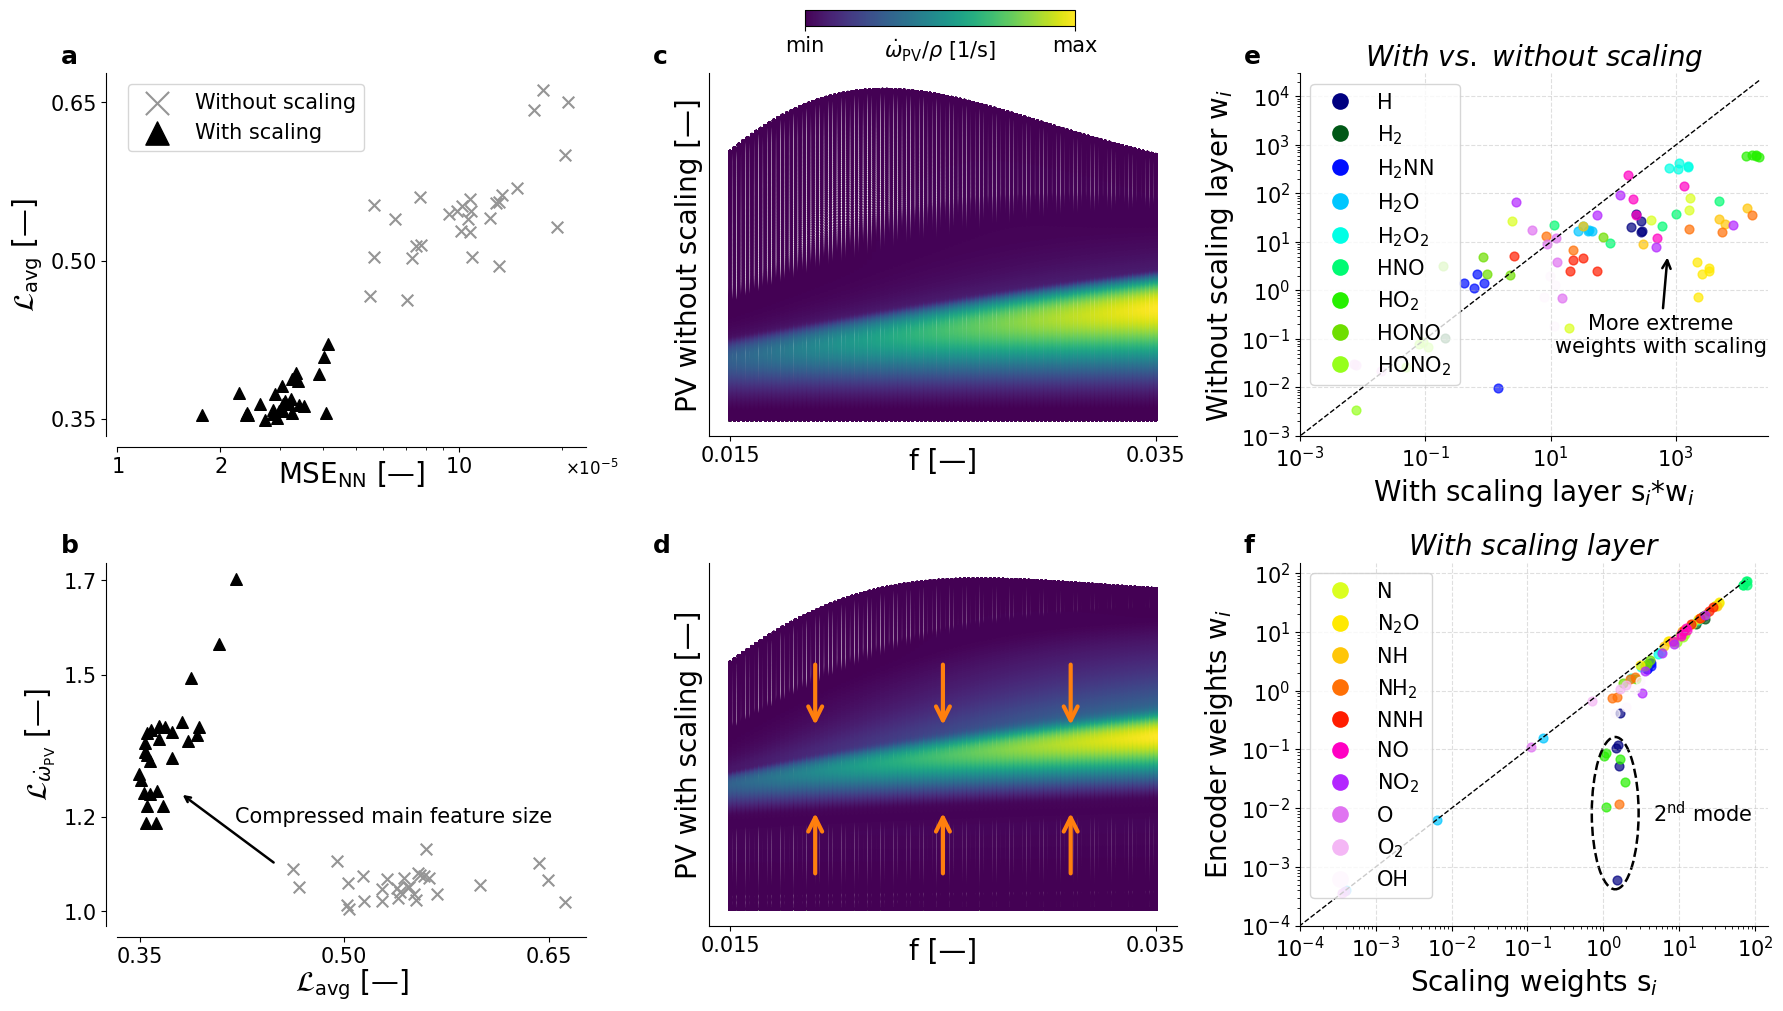

In [16]:
save = False
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/"
name = f"Figure 2 - with vs. without scaling layer"

fig, axes = plt.subplots(
    2, 3,
    figsize=(18, 11),   # 3 × your original width
    sharex=False,
    sharey=False
)

# Column-wise access
ax1 = axes[:, 0]
ax2 = axes[:, 1]
ax3 = axes[:, 2]

def plot_figure_1(ax):
    size_marker = 70
    greys = cm.get_cmap('Greys')

    # --- Top subplot ---
    ax[0].scatter(MSE_NN_without_0D, cost_avg_without_0D, label="Without scaling",
                  c=greys(0.5), marker="x", s=size_marker)
    ax[0].scatter(MSE_NN_with_0D, cost_avg_with_0D, label="With scaling",
                  c="k", marker="^", s=size_marker)

    ax[0].set_xlabel(r'$\mathrm{MSE}_{\mathrm{NN}}$ [—]', fontsize=20, labelpad=-13)
    ax[0].set_ylabel(r'$\mathcal{L}_{\mathrm{avg}}$ [—]', fontsize=20)
    ax[0].legend(fontsize=15, scatterpoints=1, markerscale=2)
    ax[0].set_xscale("log")
    ax[0].set_xticks([0.00001, 0.00002, 0.0001])
    ax[0].set_xticklabels([r'$1$', r'$2$', r'$10$'], fontsize=15)
    ax[0].set_yticks([0.35, 0.50, 0.65])
    ax[0].tick_params(axis='y', labelsize=15)
    ax[0].xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{x*10**5:g}")
    )
    ax[0].text(1.07, -0.09, r'$\times 10^{-5}$',
               transform=ax[0].transAxes, fontsize=12,
               va='center', ha='right')

    # --- Bottom subplot ---
    ax[1].scatter(cost_avg_without_0D, cost_PVsource_without_0D,
                  c=greys(0.5), marker="x", s=size_marker)
    ax[1].scatter(cost_avg_with_0D, cost_PVsource_with_0D,
                  c="k", marker="^", s=size_marker)

    ax[1].set_xlabel(r'$\mathcal{L}_{\mathrm{avg}}$ [—]', fontsize=20, labelpad=0)
    ax[1].set_ylabel(r'$\mathcal{L}_{\dot{\omega}_{\mathrm{PV}}}$ [—]', fontsize=20)
    ax[1].set_xticks([0.35, 0.50, 0.65])
    ax[1].set_yticks([1, 1.2, 1.5, 1.7])
    ax[1].tick_params(axis='both', labelsize=15)

    # Arrow + text
    ax[1].annotate("", xy=(0.38, 1.25), xytext=(0.45, 1.1),
                    arrowprops=dict(arrowstyle="->", lw=1.8, color="k"))
    ax[1].text(0.42, 1.2, "Compressed main feature size",
               fontsize=15, ha="left", va="center")

    # Spine cleanup
    for a in ax:
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.spines['left'].set_position(('outward', 8))
        a.spines['bottom'].set_position(('outward', 8))
        a.tick_params(direction="out")
    
    ax[0].set_xticklabels([r'$1$', r'$2$', r'$10$'], fontsize=15)

def plot_figure_2(ax):
    sc1 = ax[0].scatter(
        mixture_fractions_train_0D,
        -PV_optimized_train_0D_without,
        c=-PV_optimized_source_train_0D_without,
        s=3, cmap='viridis'
    )

    ax[0].set_ylabel("PV without scaling [—]", fontsize=20)
    ax[0].set_xlabel("f [—]", fontsize=20, labelpad=-13)
    ax[0].set_xticks([0.015, 0.035])
    ax[0].set_yticks([])
    ax[0].tick_params(labelsize=15)

    sc2 = ax[1].scatter(
        mixture_fractions_train_0D,
        PV_optimized_train_0D,
        c=PV_optimized_source_train_0D,
        s=3, cmap='viridis'
    )

    ax[1].set_ylabel("PV with scaling [—]", fontsize=20)
    ax[1].set_xlabel("f [—]", fontsize=20, labelpad=-13)
    ax[1].set_xticks([0.015, 0.035])
    ax[1].set_yticks([])
    ax[1].tick_params(labelsize=15)

    # Arrows
    x_arrows = [0.019, 0.025, 0.031]
    y_max = PV_optimized_train_0D.max()

    for x in x_arrows:
        ax[1].annotate("", xy=(x, 0.3*y_max), xytext=(x, 0.1*y_max),
                       arrowprops=dict(arrowstyle="->", lw=3,
                                       color="tab:orange", mutation_scale=25))
        ax[1].annotate("", xy=(x, 0.55*y_max), xytext=(x, 0.75*y_max),
                       arrowprops=dict(arrowstyle="->", lw=3,
                                       color="tab:orange", mutation_scale=25))

    for a in ax:
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)

    return sc1

def plot_figure_3(ax, full=False):
    """
    Figure 3: Weight analysis without and with scaling layer
    ax must be a length-2 array-like: [top_ax, bottom_ax]
    """

    # =========================
    # --- TOP SUBPLOT ---
    # =========================
    ax0 = ax[0]

    cmap = cm.gist_ncar
    species_names = sorted(set(species_weights_1.keys()) & set(species_weights_2.keys()))
    norm = colors.Normalize(vmin=0, vmax=len(species_names) - 1)

    for i, sp in enumerate(species_names):
        w1 = species_weights_1[sp]
        w2 = species_weights_2[sp]

        ax0.scatter(
            w1, w2,
            s=40,
            alpha=0.7,
            color=cmap(norm(i))
        )

    ax0.set_xscale("log")
    ax0.set_yscale("log")

    xmin = min(min(v) for v in species_weights_1.values())
    xmax = max(max(v) for v in species_weights_1.values())
    ax0.plot([xmin, xmax], [xmin, xmax], 'k--', linewidth=1)

    ax0.set_xlabel("With scaling layer s$_i$*w$_i$", fontsize=20)
    ax0.set_ylabel("Without scaling layer w$_i$", fontsize=20)
    ax0.set_title(r"$\mathit{With\ vs.\ without\ scaling}$", fontsize=20)

    if not full:
        ax0.set_xlim([1e-3, 3e4])
    ax0.set_ylim([1e-3, 3e4])

    ax0.tick_params(axis='both', labelsize=15)
    ax0.grid(True, which="major", linestyle="--", alpha=0.4)

    # =========================
    # --- BOTTOM SUBPLOT ---
    # =========================
    ax1 = ax[1]

    for i, sp in enumerate(scaling_weights_dict.keys()):
        sw = scaling_weights_dict[sp]
        ew = encoder_weights_dict[sp]

        ax1.scatter(
            sw, ew,
            s=40,
            alpha=0.7,
            color=cmap(norm(i))
        )

    ax1.set_xscale("log")
    ax1.set_yscale("log")

    xmin = min(min(v) for v in scaling_weights_dict.values())
    xmax = max(max(v) for v in scaling_weights_dict.values())
    ax1.plot([xmin, xmax], [xmin, xmax], 'k--', linewidth=1)

    ax1.set_xlabel("Scaling weights s$_i$", fontsize=20)
    ax1.set_ylabel("Encoder weights w$_i$", fontsize=20)
    ax1.set_title(r"$\mathit{With\ scaling\ layer }$", fontsize=20)

    if not full:
        ax1.set_xlim([1e-4, 1.5e2])
        ax1.set_ylim([1e-4, 1.5e2])

    ax1.tick_params(axis='both', labelsize=15)
    ax1.grid(True, which="major", linestyle="--", alpha=0.4)

    # =========================
    # --- LEGENDS ---
    # =========================
    species_names_latex = [s.replace('2', '$_2$') for s in species_names]
    half = int(len(species_names_latex) / 2)

    handles_top = [
        Line2D([0], [0],
               marker='o', linestyle='',
               markersize=12,
               markerfacecolor=cmap(norm(i)),
               markeredgecolor='none',
               label=sp)
        for i, sp in enumerate(species_names_latex[:half])
    ]

    handles_bottom = [
        Line2D([0], [0],
               marker='o', linestyle='',
               markersize=12,
               markerfacecolor=cmap(norm(i + half)),
               markeredgecolor='none',
               label=sp)
        for i, sp in enumerate(species_names_latex[half:])
    ]

    ax0.legend(handles=handles_top, loc="upper left", fontsize=15)
    ax1.legend(handles=handles_bottom, loc="upper left", fontsize=15)

    # =========================
    # --- ANNOTATIONS (if not full) ---
    # =========================
    if not full:
        ax0.annotate(
            "More extreme\nweights with scaling",
            fontsize=15,
            ha="center",
            xy=(0.785, 0.5),
            xytext=(0.77, 0.229),
            xycoords=ax0.transAxes,
            textcoords=ax0.transAxes,
            arrowprops=dict(arrowstyle="->", linewidth=1.8)
        )

        ellipse = Ellipse(
            xy=(0.673, 0.31),
            width=0.1,
            height=0.42,
            edgecolor="k",
            facecolor="none",
            linestyle="--",
            linewidth=1.8,
            transform=ax1.transAxes
        )
        ax1.add_patch(ellipse)

        ax1.text(
            0.673 + 0.1 / 2 + 0.03,
            0.31,
            r"2$^{\mathrm{nd}}$ mode",
            transform=ax1.transAxes,
            fontsize=15,
            ha="left",
            va="center"
        )

    # =========================
    # --- SPINES ---
    # =========================
    for a in [ax0, ax1]:
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)

        if full:
            a.spines['left'].set_position(('outward', 8))
            a.spines['bottom'].set_position(('outward', 8))



plot_figure_1(ax1)
sc = plot_figure_2(ax2)
plot_figure_3(ax3)

cax = fig.add_axes([0.45, 0.9, 0.15, 0.015])
cbar = fig.colorbar(sc, cax=cax, orientation='horizontal')
cbar.set_label(r'$\dot{\omega}_{\mathrm{PV}} / \rho$ [1/s]',
               fontsize=15, labelpad=-14)
cbar.set_ticks([sc.get_array().min(), sc.get_array().max()])
cbar.set_ticklabels(["min", "max"])
cbar.ax.tick_params(labelsize=15)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.subplots_adjust(hspace=0.35)

def add_panel_label(ax, label, x_offset=-0.12, y_offset=1.08, fontsize=18):
    ax.text(
        x_offset, y_offset,
        label,
        transform=ax.transAxes,
        fontsize=fontsize,
        fontweight="bold",
        va="top",
        ha="left",
        clip_on=False
    )
add_panel_label(ax1[0], "a")
add_panel_label(ax1[1], "b")

add_panel_label(ax2[0], "c")
add_panel_label(ax2[1], "d")

add_panel_label(ax3[0], "e")
add_panel_label(ax3[1], "f")

if save:
    plt.savefig(pathSave + name + ".png", dpi=1000, bbox_inches="tight")
    #plt.savefig(pathSave + name + ".pdf", bbox_inches="tight")

plt.show()